In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


from zipfile import ZipFile
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import os
import shutil
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Conv2D, AveragePooling2D, GlobalAveragePooling2D
from tensorflow.keras import utils
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint


np.random.seed(7)
tf.random.set_seed(7)

# Data Preparation

In [3]:
# combined_faces_zip_path = r"content\content\combined_faces.zip"

# with ZipFile(combined_faces_zip_path, 'r') as myzip:
#     myzip.extractall()
#     print('Done')

In [4]:
train_df = pd.read_csv(r"input//images_filenames_labels_train.csv")
test_df = pd.read_csv(r"input//images_filenames_labels_test.csv")

In [5]:
train_df.head()

,Unnamed: 0,filename,age
0,0,content/content/combined_faces_train/43_77_rot...,43
1,1,content/content/combined_faces_train/71_50_fli...,71
2,2,content/content/combined_faces_train/6_51_flip...,6
3,3,content/content/combined_faces_train/18_301_fl...,18
4,4,content/content/combined_faces_train/25_686_ro...,25


In [6]:
test_df.head()

,filename,age
0,/content/content/combined_faces/8_163.jpg,8
1,/content/content/combined_faces/38_66.jpg,38
2,/content/content/combined_faces/40_177.jpg,40
3,/content/content/combined_faces/36_267.jpg,36
4,/content/content/combined_faces/8_349.jpg,8


In [7]:
train_df.shape

(234400, 3)

In [8]:
test_df.shape

(10046, 2)

In [9]:
file_names = train_df['filename'].tolist()
file_names[0]

'content/content/combined_faces_train/43_77_rot_pos40.jpg'

In [10]:
file_names = train_df['filename'].tolist()
file_names = [x.replace("/","\\\\") for x in file_names]
train_df['filename'] = file_names
train_df = train_df.iloc[:,1:]
train_df.head()

,filename,age
0,content\\content\\combined_faces_train\\43_77_...,43
1,content\\content\\combined_faces_train\\71_50_...,71
2,content\\content\\combined_faces_train\\6_51_f...,6
3,content\\content\\combined_faces_train\\18_301...,18
4,content\\content\\combined_faces_train\\25_686...,25


In [11]:
file_names = test_df['filename'].tolist()
file_names = [x.replace("/","\\\\")[2:] for x in file_names]
test_df['filename'] = file_names
test_df.head()

,filename,age
0,content\\content\\combined_faces\\8_163.jpg,8
1,content\\content\\combined_faces\\38_66.jpg,38
2,content\\content\\combined_faces\\40_177.jpg,40
3,content\\content\\combined_faces\\36_267.jpg,36
4,content\\content\\combined_faces\\8_349.jpg,8


## Age classes

In [12]:
def class_labels_reassign(age):

    if 1 <= age <= 2:
        return 0
    elif 3 <= age <= 9:
        return 1
    elif 10 <= age <= 20:
        return 2
    elif 21 <= age <= 27:
        return 3
    elif 28 <= age <= 45:
        return 4
    elif 46 <= age <= 65:
        return 5
    else:
        return 6

In [13]:
train_df['target'] = train_df['age'].map(class_labels_reassign)
test_df['target'] = test_df['age'].map(class_labels_reassign)

In [35]:
train_df.head()

,filename,age,target
0,content\\content\\combined_faces_train\\43_77_...,43,4
1,content\\content\\combined_faces_train\\71_50_...,71,6
2,content\\content\\combined_faces_train\\6_51_f...,6,1
3,content\\content\\combined_faces_train\\18_301...,18,2
4,content\\content\\combined_faces_train\\25_686...,25,3


In [15]:
test_df.head()

,filename,age,target
0,content\\content\\combined_faces\\8_163.jpg,8,1
1,content\\content\\combined_faces\\38_66.jpg,38,4
2,content\\content\\combined_faces\\40_177.jpg,40,4
3,content\\content\\combined_faces\\36_267.jpg,36,4
4,content\\content\\combined_faces\\8_349.jpg,8,1


In [18]:
images = tf.data.Dataset.list_files(r"content\content\combined_faces_train\*.jpg", shuffle=False)

In [19]:
def load_image(x): 
    byte_img = tf.io.read_file(x)
    img = tf.io.decode_jpeg(byte_img)
    return img

images = images.map(load_image)
type(images)

tensorflow.python.data.ops.map_op._MapDataset

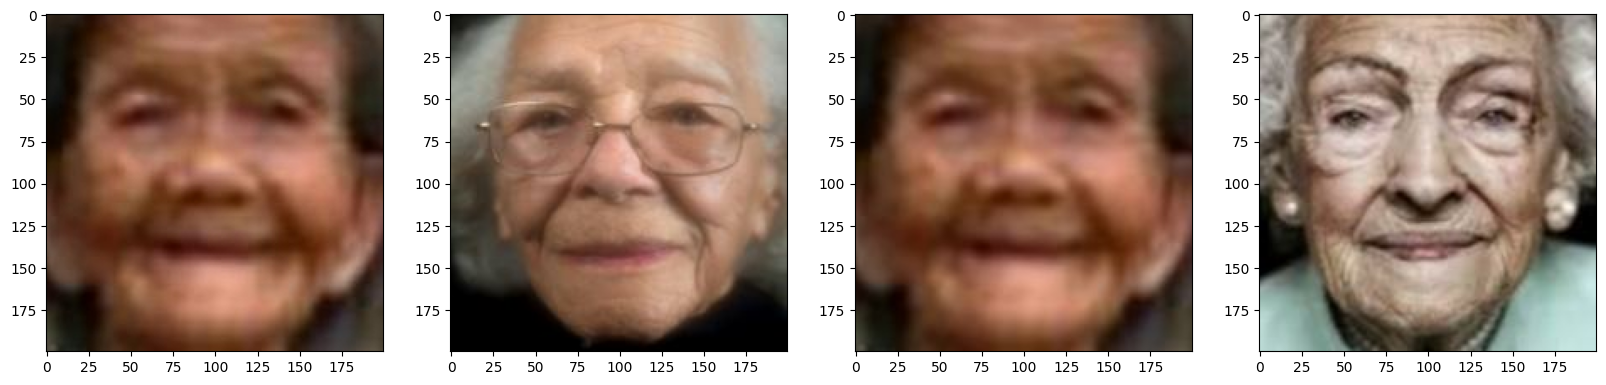

In [20]:
image_generator = images.batch(4).as_numpy_iterator()
plot_images = image_generator.next()
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, image in enumerate(plot_images):
    ax[idx].imshow(image) 
plt.show()

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_9728\923460209.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(train_df.target)


<Axes: xlabel='target', ylabel='Density'>

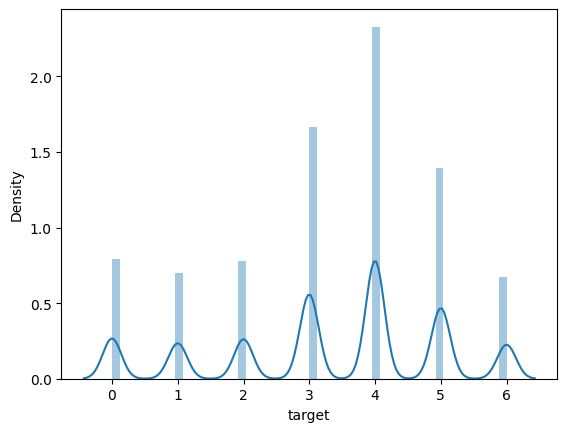

In [21]:
import seaborn as sns
sns.distplot(train_df.target)

In [31]:
train_df['target'].value_counts()

target
4    65490
3    46840
5    39190
0    22340
2    21950
1    19710
6    18880
Name: count, dtype: int64

In [32]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [ ]:
# from tensorflow.keras.preprocessing.image import load_img, img_to_array, save_img
# import numpy as np

# def augmentation_pipe(train_df, target, num_augmented)
#     df_target = train_df[train_df['target'] == target]
#     df_target.reset_index(drop=True, inplace=True)

#     for i in range(num_augmented/10):
#         row = df_target.iloc[i]
#         original_img_path = df_target.iloc[0]
#         img = load_img(original_img_path)

#         img_array = img_to_array(img)

#         img_array = np.expand_dims(img_array, axis=0)
#         batch_size = 1
#         aug_iter = datagen.flow(img_array, batch_size=batch_size)
#         for i in range(10):  
#             augmented_images = next(aug_iter)
#             augmented_img = augmented_images[0].astype(np.uint8)  
#             save_img(f"{original_img_path}{i+1}.jpg", augmented_img)
#             new_row = row
#             new_row['filename']=f"content\\content\\combined_faces\\{original_img_path}{i+1}.jpg"
            

In [ ]:
# augmentation_pipe(train_df, 0, 40000)
# augmentation_pipe(train_df, 2, 40000)
# augmentation_pipe(train_df, 1, 40000)
# augmentation_pipe(train_df, 6, 40000)
# augmentation_pipe(train_df, 5, 20000)

## Organize dataset

In [16]:
train_filenames_list = list(train_df['filename'])
train_labels_list = list(train_df['target'])

test_filenames_list = list(test_df['filename'])
test_labels_list = list(test_df['target'])

In [28]:
train_filenames_tensor =np.array(tf.constant(train_filenames_list)) 
train_labels_tensor =  np.array(tf.constant(train_labels_list)) 

test_filenames_tensor = tf.constant(test_filenames_list)
test_labels_tensor = tf.constant(test_labels_list)

# Greyscale

In [23]:
num_classes = 7

def parse_function(filename, label):
    
    image_string = tf.io.read_file(filename)
    image_decoded = tf.io.decode_jpeg(image_string, channels=1)  
    label = tf.one_hot(label, num_classes)

    return image_decoded, label

In [24]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_filenames_tensor, train_labels_tensor))
train_dataset = train_dataset.map(parse_function)
train_dataset = train_dataset.batch(512)    

test_dataset = tf.data.Dataset.from_tensor_slices((test_filenames_tensor, test_labels_tensor))
test_dataset = test_dataset.map(parse_function)
test_dataset = test_dataset.batch(512)   

# CNN

In [ ]:
final_cnn = Sequential()

final_cnn.add(Conv2D(filters=32, kernel_size=3, activation='relu', input_shape=(200, 200, 1)))   
final_cnn.add(AveragePooling2D(pool_size=(2,2)))

final_cnn.add(Conv2D(filters=64, kernel_size=3, activation='relu'))
final_cnn.add(AveragePooling2D(pool_size=(2,2)))

final_cnn.add(Conv2D(filters=128, kernel_size=3, activation='relu'))
final_cnn.add(AveragePooling2D(pool_size=(2,2)))

final_cnn.add(Conv2D(filters=256, kernel_size=3, activation='relu'))
final_cnn.add(AveragePooling2D(pool_size=(2,2)))

final_cnn.add(GlobalAveragePooling2D())

final_cnn.add(Dense(132, activation='relu'))

final_cnn.add(Dense(7, activation='softmax'))

final_cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 198, 198, 32)      320       
                                                                 
 average_pooling2d (AverageP  (None, 99, 99, 32)       0         
 ooling2D)                                                       
                                                                 
 conv2d_1 (Conv2D)           (None, 97, 97, 64)        18496     
                                                                 
 average_pooling2d_1 (Averag  (None, 48, 48, 64)       0         
 ePooling2D)                                                     
                                                                 
 conv2d_2 (Conv2D)           (None, 46, 46, 128)       73856     
                                                                 
 average_pooling2d_2 (Averag  (None, 23, 23, 128)      0

In [ ]:
final_cnn.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
tensorboard = TensorBoard(log_dir=r"output\\cnn_logs")

In [ ]:
checkpoint = ModelCheckpoint(filepath=r"output\\cnn_logs\\age_model_checkpoint.h5",
                             monitor='val_accuracy',
                             save_best_only=True,
                             save_weights_only=False,
                             verbose=1
                            )

# Model ftting

In [ ]:
final_cnn_history = final_cnn.fit(train_dataset,
                                  batch_size=512,
                                  validation_data=test_dataset,
                                  epochs=60,
                                  callbacks=[tensorboard, checkpoint],
                                  shuffle=False   
                                 )

Epoch 1/60
458/458 [==============================] - ETA: 0s - loss: 1.8014 - accuracy: 0.3014
Epoch 00001: val_accuracy improved from -inf to 0.35736, saving model to /content/drive/My Drive/Project5_AgeGenderEmotion_Detection/1.1_age_input_output/output/cnn_logs/age_model_checkpoint.h5
458/458 [==============================] - 159s 320ms/step - loss: 1.8014 - accuracy: 0.3014 - val_loss: 1.6051 - val_accuracy: 0.3574
Epoch 2/60
458/458 [==============================] - ETA: 0s - loss: 1.4575 - accuracy: 0.4115
Epoch 00002: val_accuracy improved from 0.35736 to 0.45331, saving model to /content/drive/My Drive/Project5_AgeGenderEmotion_Detection/1.1_age_input_output/output/cnn_logs/age_model_checkpoint.h5
458/458 [==============================] - 136s 297ms/step - loss: 1.4575 - accuracy: 0.4115 - val_loss: 1.3222 - val_accuracy: 0.4533
Epoch 3/60
458/458 [==============================] - ETA: 0s - loss: 1.2988 - accuracy: 0.4691
Epoch 00003: val_accuracy did not improve from 0.45

# Evaluate

In [ ]:
train_loss = final_cnn_history.history['loss']
test_loss = final_cnn_history.history['val_loss']
train_accuracy = final_cnn_history.history['accuracy']
test_accuracy = final_cnn_history.history['val_accuracy']

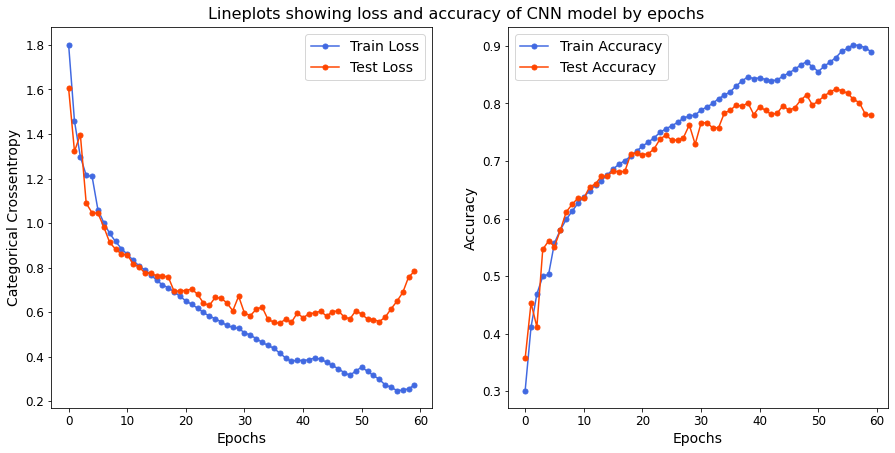

In [ ]:
fig, ax = plt.subplots(ncols=2, figsize=(15,7))

ax = ax.ravel()

ax[0].plot(train_loss, label='Train Loss', color='royalblue', marker='o', markersize=5)
ax[0].plot(test_loss, label='Test Loss', color = 'orangered', marker='o', markersize=5)

ax[0].set_xlabel('Epochs', fontsize=14)
ax[0].set_ylabel('Categorical Crossentropy', fontsize=14)

ax[0].legend(fontsize=14)
ax[0].tick_params(axis='both', labelsize=12)

ax[1].plot(train_accuracy, label='Train Accuracy', color='royalblue', marker='o', markersize=5)
ax[1].plot(test_accuracy, label='Test Accuracy', color='orangered', marker='o', markersize=5)

ax[1].set_xlabel('Epochs', fontsize=14)
ax[1].set_ylabel('Accuracy', fontsize=14)

ax[1].legend(fontsize=14)
ax[1].tick_params(axis='both', labelsize=12)

fig.suptitle(x=0.5, y=0.92, t="Lineplots showing loss and accuracy of CNN model by epochs", fontsize=16)


In [ ]:
final_cnn_score = final_cnn.evaluate(test_dataset, verbose=1)

20/20 [==============================] - 2s 109ms/step - loss: 0.7837 - accuracy: 0.7792


In [ ]:
final_cnn_labels = final_cnn.metrics_names
print(f'CNN model {final_cnn_labels[0]} \t\t= {round(final_cnn_score[0], 3)}')
print(f'CNN model {final_cnn_labels[1]} \t= {round(final_cnn_score[1], 3)}')

CNN model loss 		= 0.784
CNN model accuracy 	= 0.779


In [ ]:
final_cnn.save(r"output\\age_model.h5", save_format='h5')

### Confusion matrix

In [ ]:
final_cnn_pred = final_cnn.predict(test_dataset)
final_cnn_pred = final_cnn_pred.argmax(axis=-1)

In [ ]:
conf_mat = confusion_matrix(test_labels_list, final_cnn_pred)
conf_mat

array([[ 948,    1,    1,    1,    4,    3,    0],
       [ 164,  518,   69,   58,   26,    5,    5],
       [   3,    6,  566,  260,   91,   15,    0],
       [   1,    0,   11, 1674,  308,   13,    0],
       [   0,    0,    9,  480, 2221,   91,    6],
       [   2,    0,    0,   43,  359, 1203,   72],
       [   0,    0,    0,    8,   29,   74,  698]])

In [45]:
conf_mat = np.array([[948, 1, 1, 1, 4, 3, 0],
                        [164, 518, 69, 58, 26, 5, 5],
                        [3, 6, 566, 260, 91, 15, 0],
                        [1, 0, 11, 1674, 308, 13, 0],
                        [0, 0, 9, 480, 2221, 91, 6],
                        [2, 0, 0, 43, 359, 1203, 72],
                        [0, 0, 0, 8, 29, 74, 698]])


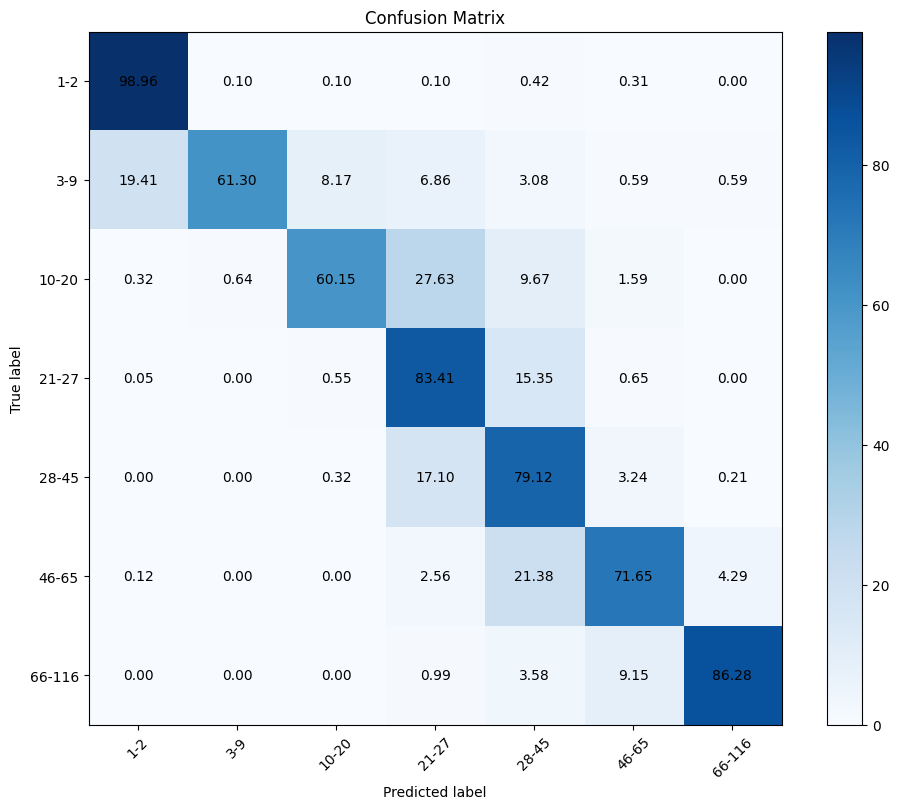

In [48]:
age_ranges = ['1-2', '3-9', '10-20', '21-27', '28-45', '46-65', '66-116']
conf_mat = conf_mat / conf_mat.sum(axis=1, keepdims=True).astype(float) * 100

plt.figure(figsize=(10, 8))
plt.imshow(conf_mat, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(age_ranges))
plt.xticks(tick_marks, age_ranges, rotation=45)
plt.yticks(tick_marks, age_ranges)

for i in range(len(age_ranges)):
    for j in range(len(age_ranges)):
        plt.text(j, i, "{:.2f}".format(conf_mat[i, j]), horizontalalignment='center', verticalalignment='center')

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [56]:
train_filenames_tensor.shape

TensorShape([234400])